# App Rating Prediction

## Description

### Objective
Make a model to predict the app rating, with other information about the app provided.

### Problem Statement
Google Play Store team is about to launch a new feature wherein, certain apps that are promising, are boosted in visibility. The boost will manifest in multiple ways including higher priority in recommendations sections (“Similar apps”, “You might also like”, “New and updated games”). These will also get a boost in search results visibility.  This feature will help bring more attention to newer apps that have the potential.

### Analysis to be Done
The problem is to identify the apps that are going to be good for Google to promote. App ratings, which are provided by the customers, is always a great indicator of the goodness of the app. The problem reduces to: predict which apps will have high ratings.

### Content
Dataset: Google Play Store data (“googleplaystore.csv”)

### Fields in the Data

App: Application name

Category: Category to which the app belongs 

Rating: Overall user rating of the app

Reviews: Number of user reviews for the app

Size: Size of the app

Installs: Number of user downloads/installs for the app

Type: Paid or Free

Price: Price of the app

Content Rating: Age group the app is targeted at - Children / Mature 21+ / Adult

Genres: An app can belong to multiple genres (apart from its main category). For example, a musical family game will belong to Music, Game, Family genres.

Last Updated: Date when the app was last updated on Play Store

Current Ver: Current version of the app available on Play Store

Android Ver: Minimum required Android version

### Steps to Perform

1. Load the data file using pandas. 

2. Check for null values in the data. Get the number of null values for each column.

3. Drop records with nulls in any of the columns. 

4. Variables seem to have incorrect type and inconsistent formatting. You need to fix them: 
    1. Size column has sizes in Kb as well as Mb. To analyze, you’ll need to convert these to numeric.
        1. Extract the numeric value from the column
        2. Multiply the value by 1,000, if size is mentioned in Mb
    2. Reviews is a numeric field that is loaded as a string field. Convert it to numeric (int/float).
    3. Installs field is currently stored as string and has values like 1,000,000+. 
        1. Treat 1,000,000+ as 1,000,000
        2. Remove ‘+’, ‘,’ from the field, convert it to integer
    4. Price field is a string and has $ symbol. Remove ‘$’ sign, and convert it to numeric.

5. Sanity checks:
    1. Average rating should be between 1 and 5 as only these values are allowed on the play store. Drop the rows that have a value outside this range.
    2. Reviews should not be more than installs as only those who installed can review the app. If there are any such records, drop them.
    3. For free apps (type = “Free”), the price should not be >0. Drop any such rows.

6. Performing univariate analysis: 
    1. Boxplot for Price
        1. Are there any outliers? Think about the price of usual apps on Play Store.
    2. Boxplot for Reviews
        1. Are there any apps with very high number of reviews? Do the values seem right?
    3. Histogram for Rating
        1. How are the ratings distributed? Is it more toward higher ratings?
    4. Histogram for Size
    5. Note down your observations for the plots made above. Which of these seem to have outliers?
    
7. Outlier treatment: 
    1. Price: From the box plot, it seems like there are some apps with very high price. A price of $200 for an application on the Play Store is very high and suspicious!
        1. Check out the records with very high price
            1. Is 200 indeed a high price?
        2. Drop these as most seem to be junk apps
    2. Reviews: Very few apps have very high number of reviews. These are all star apps that don’t help with the analysis and, in fact, will skew it. Drop records having more than 2 million reviews.
    3. Installs:  There seems to be some outliers in this field too. Apps having very high number of installs should be dropped from the analysis.
        1. Find out the different percentiles – 10, 25, 50, 70, 90, 95, 99
        2. Decide a threshold as cutoff for outlier and drop records having values more than that

8. Bivariate analysis: Let’s look at how the available predictors relate to the variable of interest, i.e., our target variable rating. Make scatter plots (for numeric features) and box plots (for character features) to assess the relations between rating and the other features.
    1. Make scatter plot/joinplot for Rating vs. Price
        1. What pattern do you observe? Does rating increase with price?
    2. Make scatter plot/joinplot for Rating vs. Size
        1. Are heavier apps rated better?
    3. Make scatter plot/joinplot for Rating vs. Reviews
        1. Does more review mean a better rating always?
    4. Make boxplot for Rating vs. Content Rating
        1. Is there any difference in the ratings? Are some types liked better?
    5. Make boxplot for Ratings vs. Category
        1. Which genre has the best ratings?
    6. For each of the plots above, note down your observation.
    
9. Data preprocessing
    1. For the steps below, create a copy of the dataframe to make all the edits. Name it inp1.
        1. Reviews and Install have some values that are still relatively very high. Before building a linear regression model, you need to reduce the skew. Apply log transformation (np.log1p) to Reviews and Installs.
        2. Drop columns App, Last Updated, Current Ver, and Android Ver. These variables are not useful for our task.
        3. Get dummy columns for Category, Genres, and Content Rating. This needs to be done as the models do not understand categorical data, and all data should be numeric. Dummy encoding is one way to convert character fields to numeric. Name of dataframe should be inp2.

10. Train test split  and apply 70-30 split. Name the new dataframes df_train and df_test.

11. Separate the dataframes into X_train, y_train, X_test, and y_test.

12. Model building
    1. Use linear regression as the technique
    2. Report the R2 on the train set

13. Make predictions on test set and report R2.

In [1]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# 1. Load the data file using pandas

In [3]:
data=pd.read_csv('googleplaystore.csv')

In [4]:
data

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


# 2. Check for null values in the data. Get the number of null values for each column

In [5]:
data.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

# 3. Drop records with nulls in any of the columns

In [6]:
data.dropna(inplace=True)
data.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

# 4.1. Size column has sizes in Kb as well as Mb

In [7]:
# convert to kb
def change(Size):
    if 'M' in Size:
        x=Size[:-1]
        x=float(x)*1000
        return x
    elif 'k' in Size:
        x=Size[:-1]
        x=float(x)
        return x
    else:
        return None

In [8]:
# fix formatting
data['Size']=data['Size'].map(change)

In [9]:
data.Size

0        19000.0
1        14000.0
2         8700.0
3        25000.0
4         2800.0
          ...   
10834     2600.0
10836    53000.0
10837     3600.0
10839        NaN
10840    19000.0
Name: Size, Length: 9360, dtype: float64

In [10]:
# recheck for nulls
data.isnull().sum()

App                  0
Category             0
Rating               0
Reviews              0
Size              1637
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          0
Android Ver          0
dtype: int64

In [11]:
# remove nulls and recheck
data.Size.fillna(method='ffill',inplace=True)
data.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

# 4.2. Reviews is a numeric field that is loaded as a string field. Convert it to numeric (int/float)

In [12]:
data['Reviews']=data['Reviews'].astype('int')
data.dtypes

App                object
Category           object
Rating            float64
Reviews             int32
Size              float64
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

# 4.3. Installs field is currently stored as string and has values like 1,000,000+

In [13]:
data.Installs

0            10,000+
1           500,000+
2         5,000,000+
3        50,000,000+
4           100,000+
            ...     
10834           500+
10836         5,000+
10837           100+
10839         1,000+
10840    10,000,000+
Name: Installs, Length: 9360, dtype: object

In [14]:
# Treat 1,000,000+ as 1,000,000, remove the '+'
data['Installs']=data['Installs'].str.replace('[+,]','')
data.Installs

0           10000
1          500000
2         5000000
3        50000000
4          100000
           ...   
10834         500
10836        5000
10837         100
10839        1000
10840    10000000
Name: Installs, Length: 9360, dtype: object

In [15]:
# Convert to integer
data['Installs']=data['Installs'].astype('int')
data.dtypes

App                object
Category           object
Rating            float64
Reviews             int32
Size              float64
Installs            int32
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

# 4.4. Price field is a string and has \\$ symbol. Remove \'$' sign, and convert it to numeric

In [16]:
data.Price.sort_values(ascending=True)

2300     $0.99
3405     $0.99
6936     $0.99
7665     $0.99
4260     $0.99
         ...  
3313         0
3314         0
3315         0
3309         0
10840        0
Name: Price, Length: 9360, dtype: object

In [17]:
# Remove $
data['Price']=data['Price'].str.replace('[$]','')
data.Price.sort_values(ascending=True)

0          0
6685       0
6684       0
6682       0
6681       0
        ... 
2378    9.99
2401    9.99
6205    9.99
2246    9.99
5475    9.99
Name: Price, Length: 9360, dtype: object

In [18]:
# Convert to numeric
data['Price']=data['Price'].astype('float')
data.dtypes

App                object
Category           object
Rating            float64
Reviews             int32
Size              float64
Installs            int32
Type               object
Price             float64
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

# 5. Sanity checks

### 5.1. Average rating should be between 1 and 5 as only these values are allowed on the play store. Drop the rows that have a value outside this range

In [19]:
# Check above 5
np.sum(data['Rating']>5)

0

In [20]:
# Check below 1
np.sum(data['Rating']<1)

0

### 5.2. Reviews should not be more than installs as only those who installed can review the app. If there are any such records, drop them

In [21]:
# Check for reviews > installs
np.sum(data['Reviews']>data['Installs'])

7

In [22]:
# Drop reviews > installs
data.drop(data[data['Reviews'] > data['Installs']].index, inplace = True)
np.sum(data['Reviews']>data['Installs'])

0

### 5.3. For free apps (type = “Free”), the price should not be >0. Drop any such rows

In [23]:
np.sum(data[(data['Type']=='Free') & (data['Price']>0)])

App               0.0
Category          0.0
Rating            0.0
Reviews           0.0
Size              0.0
Installs          0.0
Type              0.0
Price             0.0
Content Rating    0.0
Genres            0.0
Last Updated      0.0
Current Ver       0.0
Android Ver       0.0
dtype: float64

# 6. Performing univariate analysis

### 6.1. Boxplot for Price

<AxesSubplot:xlabel='Price'>

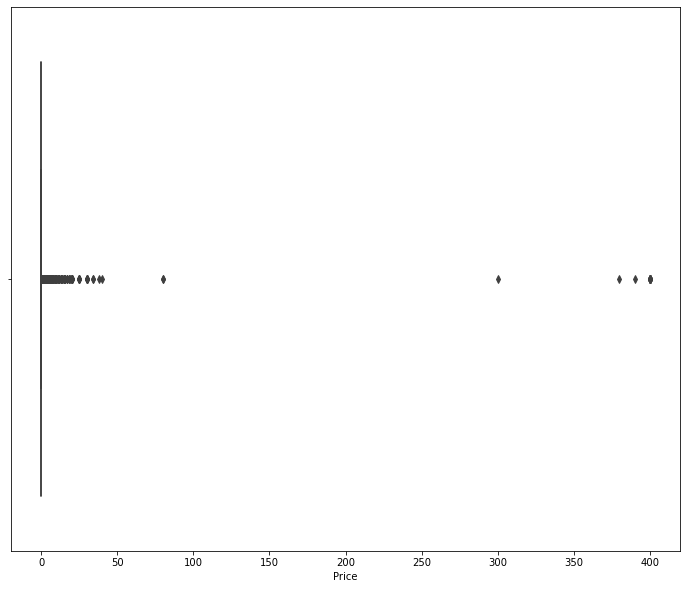

In [24]:
plt.figure(figsize=[12,10])
sns.boxplot(data['Price'])

6.1.1. Are there any outliers? Think about the price of usual apps on Play Store

    Yes, most paid apps are usually less than $10. This boxplot shows multiple outliers up to about $400.

### 6.2. Boxplot for Reviews

<AxesSubplot:xlabel='Reviews'>

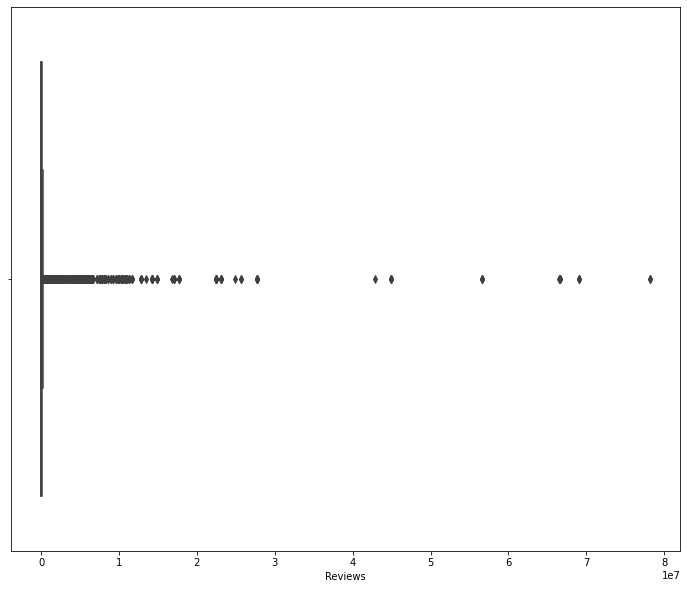

In [25]:
plt.figure(figsize=[12,10])
sns.boxplot(data['Reviews'])

6.2.1. Are there any apps with very high number of reviews? Do the values seem right?

    There are multiple apps with a very high number of reviews. The scale on the bottom indicates that there are numerous outliers, with some apps even having 80,000,000 reviews.

### 6.3. Histogram for Rating

<AxesSubplot:xlabel='Rating', ylabel='Count'>

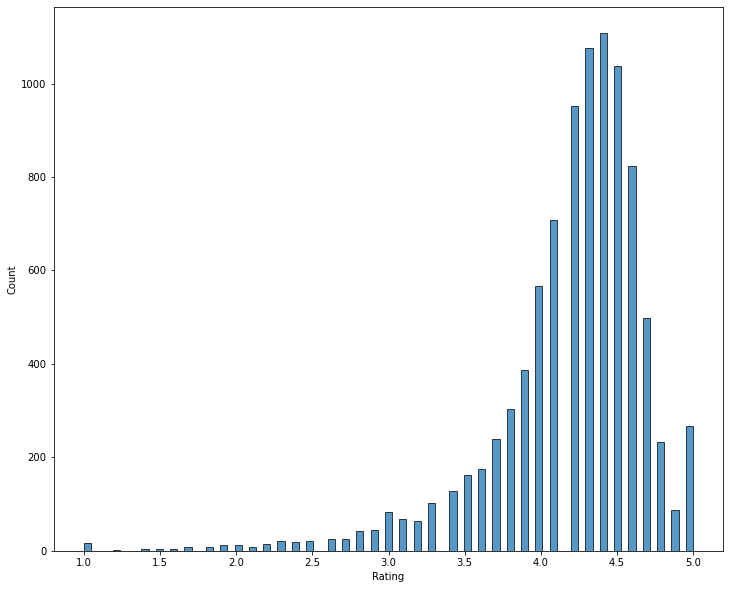

In [26]:
plt.figure(figsize=[12,10])
sns.histplot(data['Rating'])

6.3.1. How are the ratings distributed? Is it more toward higher ratings?

    The ratings are left-skewed, with many more high ratings than low.

### 6.4. Histogram for Size

<AxesSubplot:xlabel='Size', ylabel='Count'>

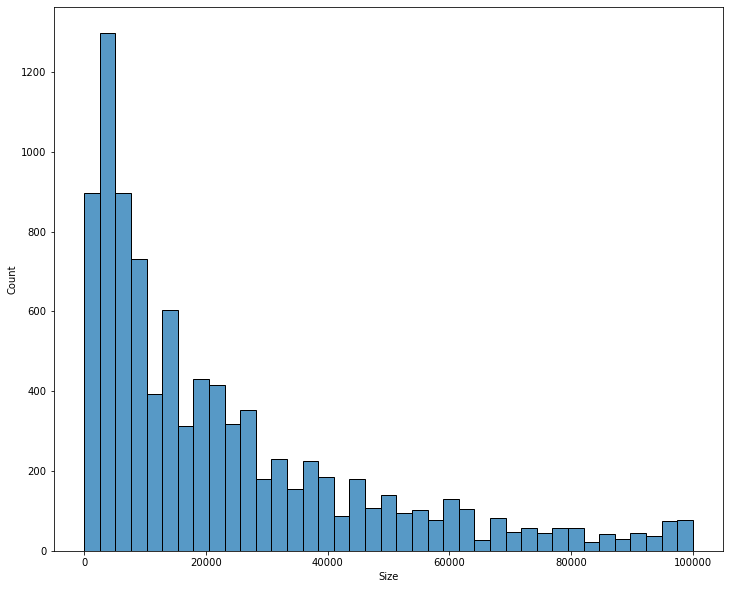

In [27]:
plt.figure(figsize=[12,10])
sns.histplot(data['Size'])

### 6.5. Note down your observations for the plots made above. Which of these seem to have outliers?

    All of the above charts are likely to have outliers. The price and reviews charts show numerous outliers on the upper end, while the ratings and size charts are both highly skewed, and are therefore likely to have outliers.

# 7. Outlier Treatment

### 7.1. Price: From the box plot, it seems like there are some apps with very high price. A price of $200 for an application on the Play Store is very high and suspicious!

7.1.1. Check out the records with very high price

In [28]:
# check what is considered 'high'
data.Price.quantile([0.1,0.25,0.5,0.75,0.9,0.95,0.99])

0.10    0.00
0.25    0.00
0.50    0.00
0.75    0.00
0.90    0.00
0.95    1.99
0.99    8.99
Name: Price, dtype: float64

7.1.1.1. Is 200 indeed a high price?
    
    The above table shows that $8.99 is the start of the 99th percentile, so $200 is definitely high.

7.2.1. Drop these as most seem to be junk apps

In [29]:
data.drop(data[data['Price']>200].index, inplace = True)
np.sum(data['Price']>200)

0

### 7.2. Reviews: Very few apps have very high number of reviews. These are all star apps that don’t help with the analysis and, in fact, will skew it. Drop records having more than 2 million reviews

In [30]:
data.drop(data[data['Reviews']>2000000].index, inplace = True)
np.sum(data['Reviews']>2000000)

0

### 7.3. Installs:  There seems to be some outliers in this field too. Apps having very high number of installs should be dropped from the analysis.

7.3.1. Find out the different percentiles – 10, 25, 50, 70, 90, 95, 99

In [31]:
data.Installs.quantile([0.1,0.25,0.5,0.7,0.9,0.95,0.99])

0.10         1000.0
0.25        10000.0
0.50       500000.0
0.70      1000000.0
0.90     10000000.0
0.95     10000000.0
0.99    100000000.0
Name: Installs, dtype: float64

7.3.2. Decide a threshold as cutoff for outlier and drop records having values more than that

In [32]:
# as both 0.9 and 0.95 have the same number of installs at 10,000,000, I will drop records with more than this number
data.drop(data[data['Installs']>10000000].index, inplace = True)
np.sum(data['Reviews']>10000000)

0

# 8. Bivariate analysis: Let’s look at how the available predictors relate to the variable of interest, i.e., our target variable rating. Make scatter plots (for numeric features) and box plots (for character features) to assess the relations between rating and the other features.

### 8.1. Make scatter plot/jointplot for Rating vs. Price

<Figure size 864x720 with 0 Axes>

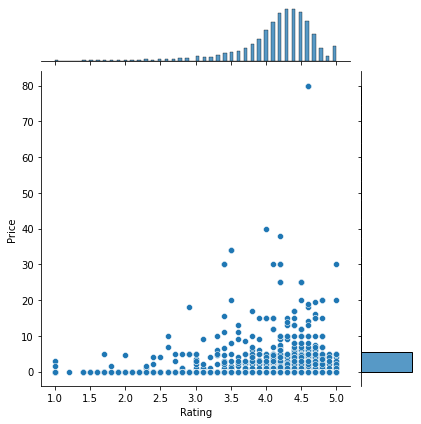

In [33]:
# jointplot
plt.figure(figsize=[12,10])
sns.jointplot(x='Rating',y='Price',data=data)

<AxesSubplot:xlabel='Rating', ylabel='Price'>

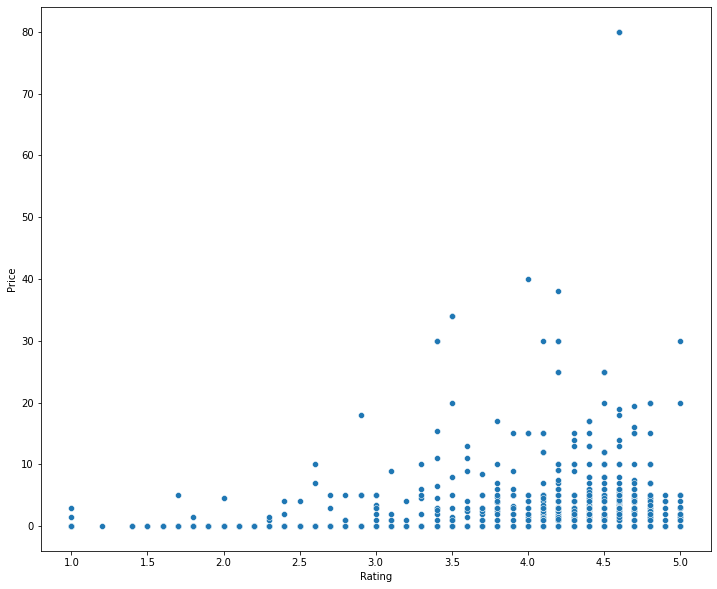

In [34]:
# scatterplot
plt.figure(figsize=[12,10])
sns.scatterplot(x='Rating',y='Price',data=data)

8.1.1. What pattern do you observe? Does rating increase with price?

    Although there is no clear and obvious pattern, the higher-priced apps do have fewer low ratings. This indicated that rating does increase with price.

### 8.2. Make scatter plot/joinplot for Rating vs. Size

<Figure size 864x720 with 0 Axes>

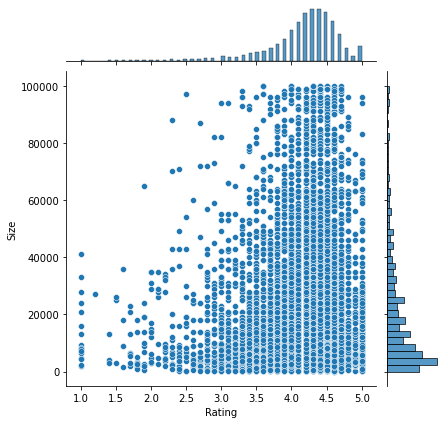

In [35]:
# jointplot
plt.figure(figsize=[12,10])
sns.jointplot(x='Rating',y='Size',data=data)

<AxesSubplot:xlabel='Rating', ylabel='Size'>

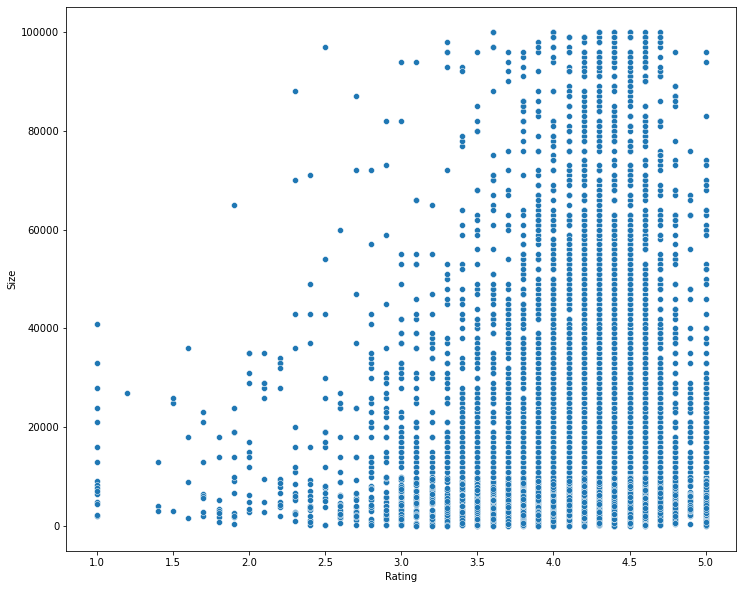

In [36]:
# scatterplot
plt.figure(figsize=[12,10])
sns.scatterplot(x='Rating',y='Size',data=data)

8.2.1. Are heavier apps rated better?

    Similarly to 8.1.1., although there is no clear and obvious pattern, the heavier apps do have fewer low ratings. This indicated that rating does increase with app size.

### 8.3. Make scatter plot/joinplot for Rating vs. Reviews

<Figure size 864x720 with 0 Axes>

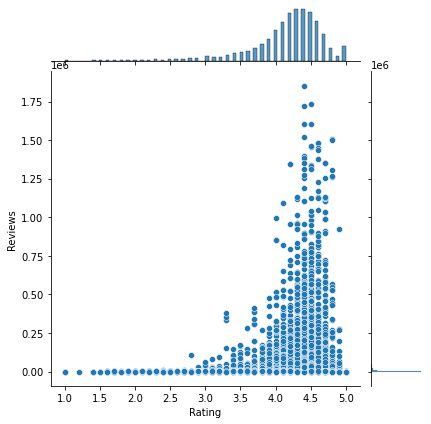

In [37]:
# jointplot
plt.figure(figsize=[12,10])
sns.jointplot(x='Rating',y='Reviews',data=data)

<AxesSubplot:xlabel='Rating', ylabel='Reviews'>

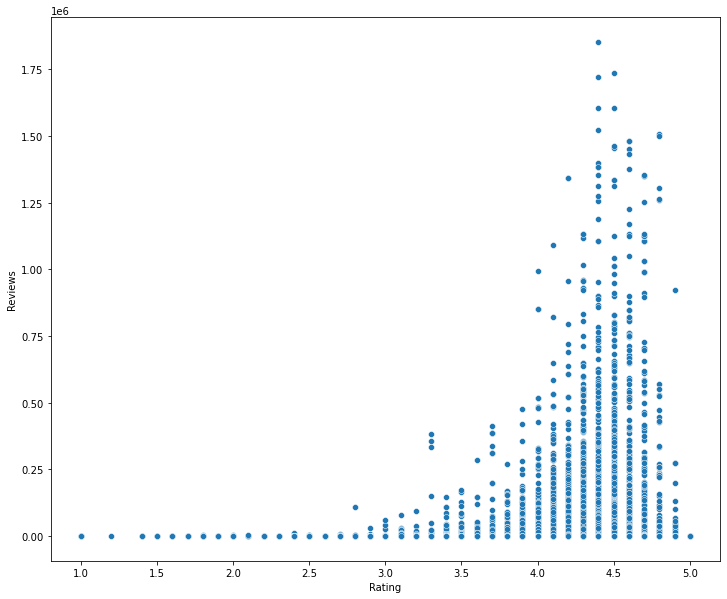

In [38]:
# scatterplot
plt.figure(figsize=[12,10])
sns.scatterplot(x='Rating',y='Reviews',data=data)

8.3.1. Does more review mean a better rating always?

    These charts show that higher rated apps tend to have more reviews, both positive and negative.

### 8.4. Make boxplot for Rating vs. Content Rating

<AxesSubplot:xlabel='Rating', ylabel='Content Rating'>

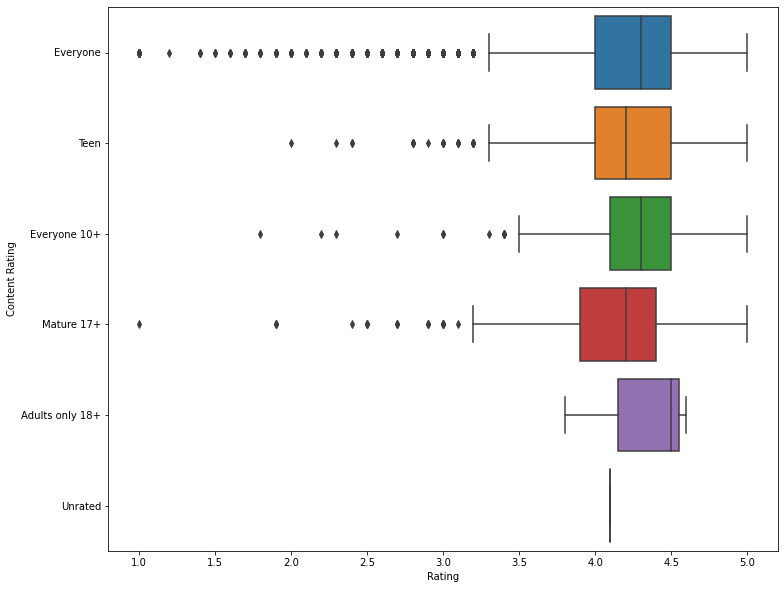

In [39]:
plt.figure(figsize=[12,10])
sns.boxplot(x='Rating',y='Content Rating',data=data)

8.4.1. Is there any difference in the ratings? Are some types liked better?

    This boxplot shows that while all 'content rating' groups have roughly the same rating, the apps available to everyone have the most outliers and the biggest range, while the adult only apps have no outliers. The other groups fall inbetween.

### 8.5. Make boxplot for Ratings vs. Category

<AxesSubplot:xlabel='Rating', ylabel='Category'>

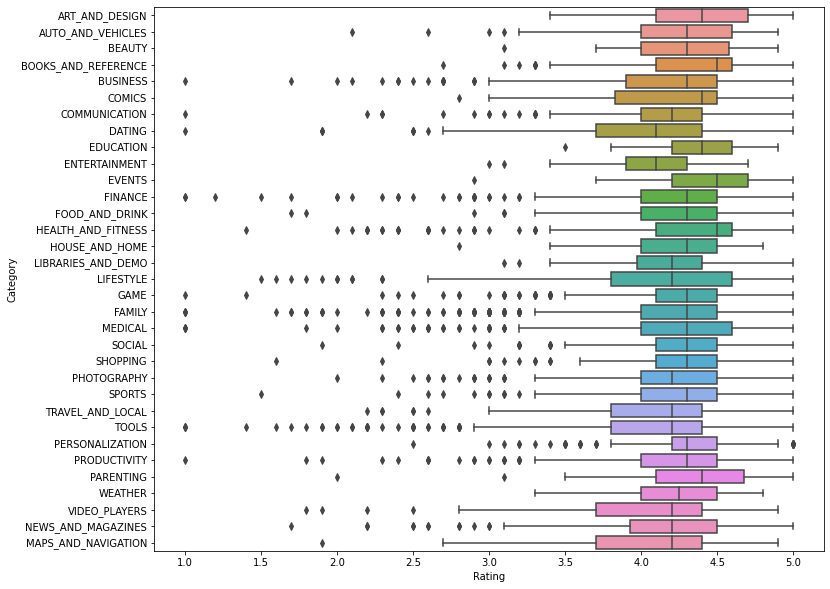

In [40]:
plt.figure(figsize=[12,10])
sns.boxplot(x='Rating',y='Category',data=data)

8.5.1. Which genre has the best ratings?

    From this, I would say that the 'events' apps have the best ratings. They have one of the highest means, very few outliers, quite a low range.

# 9. Data preprocessing

### 9.1. For the steps below, create a copy of the dataframe to make all the edits. Name it inp1.

In [41]:
inp1=data.copy()

9.1.1. Reviews and Install have some values that are still relatively very high. Before building a linear regression model, you need to reduce the skew. Apply log transformation (np.log1p) to Reviews and Installs.

In [42]:
# reviews
inp1.Reviews=np.log1p(inp1.Reviews)
inp1.Reviews

0         5.075174
1         6.875232
2        11.379520
4         6.875232
5         5.123964
           ...    
10834     2.079442
10836     3.663562
10837     1.609438
10839     4.744932
10840    12.894981
Name: Reviews, Length: 8496, dtype: float64

In [43]:
# installs
inp1.Installs=np.log1p(inp1.Installs)
inp1.Installs

0         9.210440
1        13.122365
2        15.424949
4        11.512935
5        10.819798
           ...    
10834     6.216606
10836     8.517393
10837     4.615121
10839     6.908755
10840    16.118096
Name: Installs, Length: 8496, dtype: float64

9.2.1. Drop columns App, Last Updated, Current Ver, and Android Ver. These variables are not useful for our task.

In [44]:
inp1.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')

In [45]:
inp1.drop(['App','Last Updated','Current Ver','Android Ver'],axis=1,inplace=True)
inp1.columns

Index(['Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price',
       'Content Rating', 'Genres'],
      dtype='object')

9.3.1. Get dummy columns for Category, Genres, and Content Rating. This needs to be done as the models do not understand categorical data, and all data should be numeric. Dummy encoding is one way to convert character fields to numeric. Name of dataframe should be inp2.

In [46]:
# also creating dummy for 'Type', to avoid an error later in the code
inp2=pd.get_dummies(inp1,columns=['Category','Genres','Content Rating','Type'])
inp2.head()

,Rating,Reviews,Size,Installs,Price,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,...,Genres_Weather,Genres_Word,Content Rating_Adults only 18+,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated,Type_Free,Type_Paid
0,4.1,5.075174,19000.0,9.210440,0.0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,3.9,6.875232,14000.0,13.122365,0.0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,4.7,11.379520,8700.0,15.424949,0.0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,4.3,6.875232,2800.0,11.512935,0.0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
5,4.4,5.123964,5600.0,10.819798,0.0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


# 10. Train test split  and apply 70-30 split. Name the new dataframes df_train and df_test.

In [47]:
from sklearn.model_selection import train_test_split
df_train,df_test=train_test_split(inp2,test_size=0.3)
print(df_train.shape)
print(df_test.shape)

(5947, 161)
(2549, 161)


# 11. Separate the dataframes into X_train, y_train, X_test, and y_test.

In [48]:
y_train=df_train.pop('Rating')
x_train=df_train
y_test=df_test.pop('Rating')
x_test=df_test

# 12. Model building

### 12.1. Use linear regression as the technique

In [49]:
from sklearn.linear_model import LinearRegression
linear_reg=LinearRegression()

In [50]:
linear_reg.fit(x_train,y_train)

LinearRegression()

### 12.2. Report the R2 on the train set

In [51]:
from sklearn.metrics import r2_score
y_pred_train=linear_reg.predict(x_train)
print(r2_score(y_pred_train,y_train))

-4.065099323826989


# 13. Make predictions on test set and report R2.

In [52]:
y_pred_test=linear_reg.predict(x_test)
print(r2_score(y_pred_test,y_test))

-3.5901231464039434
